# Figure with Stan model fits to CD8 data

Results of Stan fits to Leiden-clustered data for the CD8 T cells.
The figure shows the fits of the 4 models to the cell counts and frequencies,
and a number of parameter estimates, including the differentiation matrix

In [2]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import pandas as pd
import scipy.stats as sts
import matplotlib
import cmdstanpy

import scdynsys.plots as plots
import scdynsys.utilities as utils

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

## Import data

The data was created in the notebook `SequentialApproachFitting.ipynb`

In [3]:
## Import data and stan fits

data_file = "../results/data_SA_fitting.pkl"
lineage = "CD8"

with open(data_file, 'rb') as f:
    data_dict = pickle.load(f)
    
fit_results = data_dict["fit_results"]
celltype_names = data_dict["celltype_names"]
count_scaling = data_dict["count_scaling"]

plotted_models = ["M1", "M2", "M3", "M4"]
model_names = ["Model I", "II", "III", "IV"]
celltype_colors = tabcolors

num_models = len(plotted_models)
num_clusters = len(celltype_names)

# import fancy names used in the SA preprocessing figure

fancy_names_file = f"../results/fancy_names_SA_{lineage}.pkl"
with open(fancy_names_file, 'rb') as f:
    fancy_names = pickle.load(f)

fancy_celltype_names = [fancy_names[name] for name in celltype_names]

## Create the figure object

Individual panels will be added below. We use `wax` rows per model.

In [4]:
wax = 2
gs = GridSpec(num_clusters+1, wax*(num_models+2))

fig = plt.figure(figsize=(14, 2*num_clusters))

labx, laby = -0.05, 1.05

fig.subplots_adjust(wspace=0.2, hspace=0.1)

<Figure size 1400x1600 with 0 Axes>

## Plot the cell counts and frequencies

The top panels show the cell counts, the bottom panels show the fits to each of the subsets.

In [5]:
# get count axes

count_axs = []

ax = None
for i in range(num_models):
    a = wax*i
    ax = fig.add_subplot(gs[0,a:a+wax], sharey=ax)
    count_axs.append(ax)
    
# get freq axes

freq_axss = [[] for _ in range(num_models)]

for j in range(num_clusters):
    ax = None
    for i in range(num_models):
        a = wax*i
        ax = fig.add_subplot(gs[j+1,a:a+wax], sharey=ax)
        freq_axss[i].append(ax)

for i, M in enumerate(plotted_models):
    stan_fit, stan_inits, stan_data, diagnostics = fit_results[M]
    plots.plot_stan_fits_fancy(
        count_axs[i],
        freq_axss[i],
        stan_fit, stan_data,
        count_scaling,
        celltype_colors,
        minor_thresholds=(1.8, 0.5)
    )
    
# add / remove labels
def title_in_graph(ax, title, pos, align):
    ax.text(*pos, title, transform=ax.transAxes, **align)

toppos = (0.95, 0.95)
topaln = dict(va='top', ha='right')

botpos = (0.95, 0.05)
botaln = dict(va='bottom', ha='right')

title_in_graph(count_axs[0], f"{lineage}+ T cell\nnumbers", toppos, topaln) 

# adjust positions of labels?
lposses = {
    #"DN TRM" : (toppos, topaln)
}

for j in range(num_models):
    if j > 0:
        plt.setp(count_axs[j].get_yticklabels(), visible=False)
    plt.setp(count_axs[j].get_xticklabels(), visible=False)
    for i in range(num_clusters):
        name = celltype_names[i]
        fancy_name = fancy_names[name]
        if j == 0:
            lpos, laln = lposses.get(name, (botpos, botaln))
            title_in_graph(freq_axss[0][i], fancy_name, lpos, laln)
        if j > 0:
            plt.setp(freq_axss[j][i].get_yticklabels(which="both"), visible=False)
        if i < num_clusters-1:
            plt.setp(freq_axss[j][i].get_xticklabels(), visible=False)
    freq_axss[j][-1].set_xlabel("DPI")
    count_axs[j].set_title(model_names[j])
    

fig.align_ylabels([count_axs[0]] + [freq_axss[0][i] for i in range(num_clusters)])
    
Ax = fig.add_subplot(gs[:2,0:wax*2])

Ax.axis('off')
Ax.text(labx, laby, "A", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.05, 1.05, 'A')

## Make a violin plot for the parameter estimates

Include $\lambda_E$, $\lambda_L$ and $p_0$. Note that $\lambda_E$ and $\lambda_L$ are called $\rho$ and $\eta$ in the Stan model for historical reasons.

In [6]:
# plot parameter estimates

pos = [i for i, _ in enumerate(celltype_names)]
xlabs = celltype_names

model_key = "M2"
sam = fit_results[model_key][0]

rho = sam["rho"]
rho_loc = sam["rho_loc"]
eta = sam["eta"]
eta_loc = sam["eta_loc"]
p0 = sam["p0"]


lam_E = -rho
lam_E_loc = -rho_loc
lam_L = -eta
lam_L_loc = -eta_loc

# new parameter naming conventions
ylabs = ["$\\lambda_E$ (per day)", "$\\lambda_L$  (per day)", "$p_0$"]

# convert growth rates to net loss rates lambda
axs = []

ax = fig.add_subplot(gs[0,4*wax+1:])
plots.plot_mpd(ax, pos, lam_E)
ax.set_xticks(pos)
ax.set_xticklabels([])
ax.set_ylabel("early net loss rate\n" + ylabs[0])
axs.append(ax)

ax = fig.add_subplot(gs[1,4*wax+1:])
plots.plot_mpd(ax, pos, lam_L)
ax.set_xticks(pos)
ax.set_xticklabels([])
ax.set_ylabel("late net loss rate\n" + ylabs[1])
axs.append(ax)

ax = fig.add_subplot(gs[2,4*wax+1:])
plots.plot_mpd(ax, pos, p0)
ax.set_xticks(pos)
ax.set_ylabel("initial frequency\n" + ylabs[2])
axs.append(ax)

axs[-1].set_xticklabels(fancy_celltype_names, rotation=45, ha='right')

# indicate where the estimates are from
model_name = model_names[plotted_models.index(model_key)].split()[-1]
axs[0].set_title(f"model {model_name}")

# horizontal line at 0.0
for ax in axs[:2]:
    ax.axhline(y=0, color='0.7', linestyle='--')


fig.align_ylabels(axs)

Ax = fig.add_subplot(gs[0:2,4*wax+1:])

Ax.axis('off')
Ax.text(labx, laby, "B", fontsize='xx-large', transform=Ax.transAxes)

Text(-0.05, 1.05, 'B')

## Plot the differentation matrix

The exit rates from compartments are shown as negative values on the diagonal.

In [7]:
## Plot differentiation matrix

ax = fig.add_subplot(gs[5:7,4*wax+1:])

cax = fig.add_subplot(gs[7,4*wax+1:])
cax.axis('off')

model_key = "M4"
sam = fit_results[model_key][0]

plots.plot_diff_matrix(
    ax, sam["Q"], fancy_celltype_names, 
    colorbar_args=dict(ax=cax, orientation="horizontal"),
    num_cticks=4, ctick_formatter="${:0.2f}$",
    x_rotation=45, y_rotation=45
)

# adjust location of "destination" label
ax.yaxis.set_label_coords(-0.3,0.8)

model_name = model_names[plotted_models.index(model_key)].split()[-1]
ax.set_title(f"model {model_name}")

ax.text(labx, laby, "C", fontsize='xx-large', transform=ax.transAxes)

Text(-0.05, 1.05, 'C')

## Show the figure

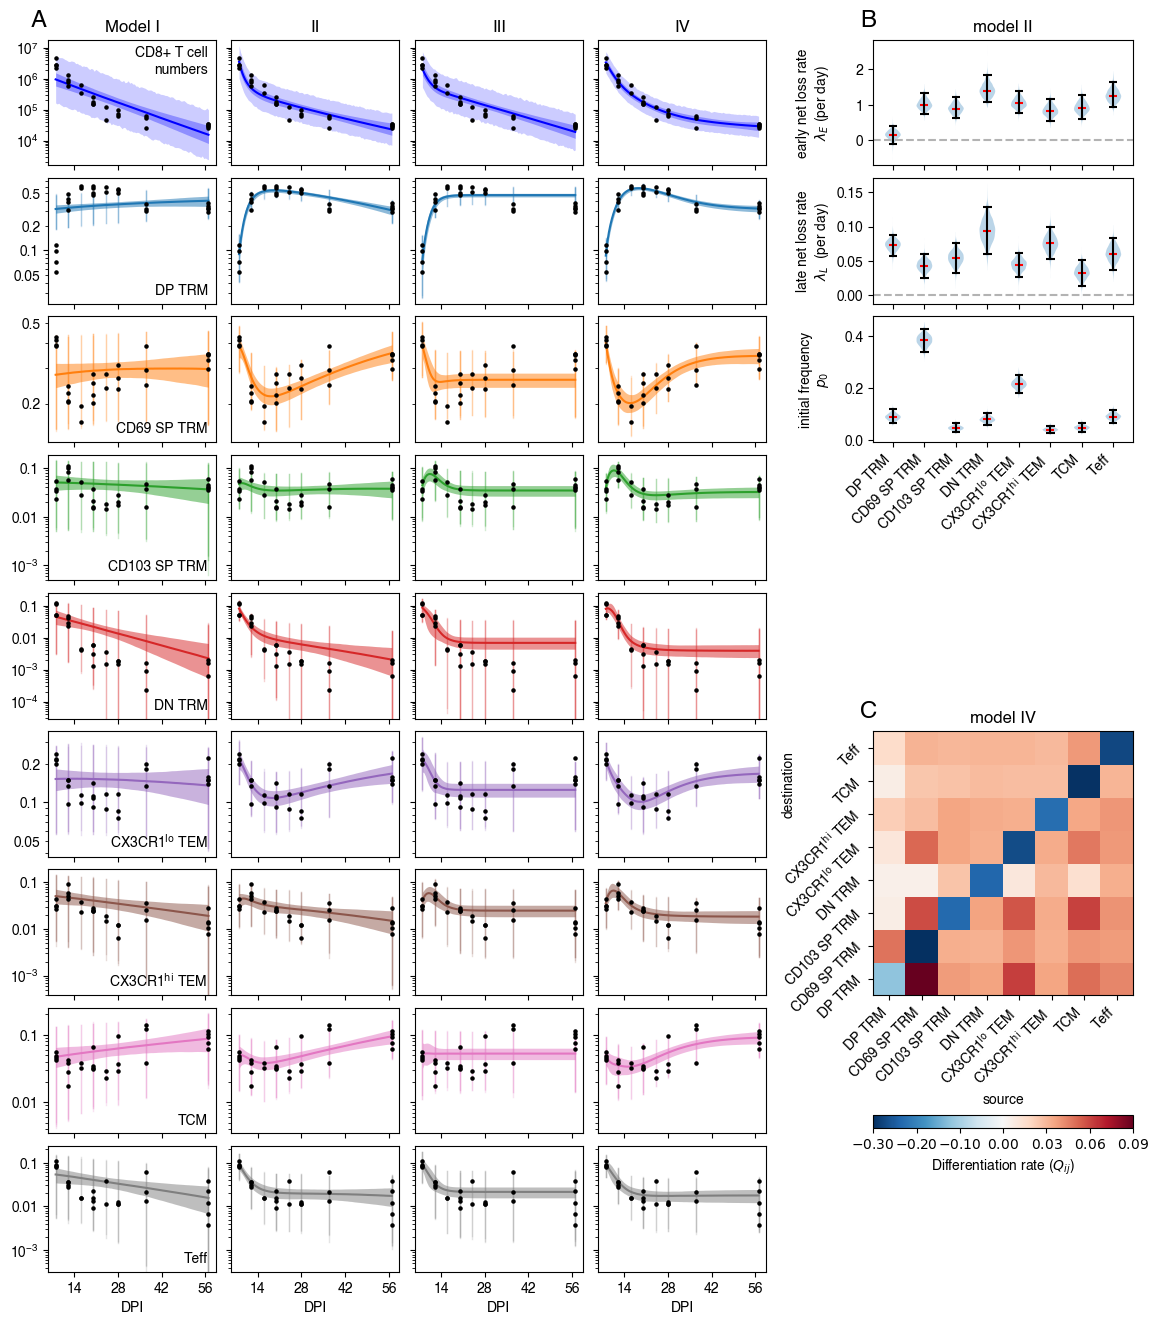

In [8]:
fig

In [9]:
#fig.savefig("../results/FigureSAFitCD8.pdf", bbox_inches='tight')